<h2>Comparación de la precisión de un clasificador de imágenes con el uso de filtros y sin filtros <h2\>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
import cv2

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalizacion
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 51s 0us/step


En la siguiente parte del código, experimentaremos con diferentes filtros aplicados a las imagenes con el objetivo de comparar la precisión del modelo de clasificación con la implementación de filtros. El modelo será entrenado con estas imagenes con filtro y se comparará la precisión obtenida con la precisión del modelo con imagenes sin filtro.

In [ ]:
def apply_sobel(images):
    
    filtered = np.zeros_like(images)
    for i in range(len(images)):
        # Convert to grayscale first for edge detection
        gray = cv2.cvtColor((images[i] * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        sobel = np.sqrt(sobelx**2 + sobely**2)
        # Normalize and convert back to 3 channels
        sobel = cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX)
        filtered[i] = cv2.cvtColor(sobel.astype('uint8'), cv2.COLOR_GRAY2RGB) / 255.0
    return filtered

def apply_gaussian(images):
    
    filtered = np.zeros_like(images)
    for i in range(len(images)):
        # Convert to uint8, apply filter, then convert back
        img_uint8 = (images[i] * 255).astype('uint8')
        filtered_uint8 = cv2.GaussianBlur(img_uint8, (5, 5), 1)
        filtered[i] = filtered_uint8.astype('float32') / 255.0
    return filtered

def apply_median(images):
   
    filtered = np.zeros_like(images)
    for i in range(len(images)):
        # Convert to uint8, apply filter, then convert back
        img_uint8 = (images[i] * 255).astype('uint8')
        filtered_uint8 = cv2.medianBlur(img_uint8, 3)
        filtered[i] = filtered_uint8.astype('float32') / 255.0
    return filtered

def apply_laplacian(images):

    filtered = np.zeros_like(images)
    for i in range(len(images)):
        gray = cv2.cvtColor((images[i] * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)
        laplacian = cv2.Laplacian(gray, cv2.CV_64F)
        laplacian = cv2.normalize(laplacian, None, 0, 255, cv2.NORM_MINMAX)
        filtered[i] = cv2.cvtColor(laplacian.astype('uint8'), cv2.COLOR_GRAY2RGB) / 255.0
    return filtered


x_train_sobel = apply_sobel(x_train)
x_test_sobel = apply_sobel(x_test)


x_train_gaussian = apply_gaussian(x_train)
x_test_gaussian = apply_gaussian(x_test)


x_train_median = apply_median(x_train)
x_test_median = apply_median(x_test)

x_train_laplacian = apply_laplacian(x_train)
x_test_laplacian = apply_laplacian(x_test)


In [ ]:
def create_model():
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [ ]:
## Entrenando y evaluando modelos

results = {}

# Original (sin filtro)
print("\n Entrenando con imagenes originales...")
model = create_model()
history = model.fit(x_train, y_train, epochs=10, batch_size=64, 
                    validation_data=(x_test, y_test), verbose=1)
results['original'] = history.history

# Sobel imagenes con filtro
print("\nEntrenando con imagenes sobel...")
model_sobel = create_model()
history_sobel = model_sobel.fit(x_train_sobel, y_train, epochs=10, batch_size=64, 
                               validation_data=(x_test_sobel, y_test), verbose=1)
results['sobel'] = history_sobel.history

# Filtro Gaussiano
print("\nEntrenando con imagenes gaussianas...")
model_gaussian = create_model()
history_gaussian = model_gaussian.fit(x_train_gaussian, y_train, epochs=10, batch_size=64, 
                                    validation_data=(x_test_gaussian, y_test), verbose=1)
results['gaussian'] = history_gaussian.history

# Filtro mediano
print("\nEntrenando con imagenes medianas...")
model_median = create_model()
history_median = model_median.fit(x_train_median, y_train, epochs=10, batch_size=64, 
                                 validation_data=(x_test_median, y_test), verbose=1)
results['median'] = history_median.history

# Filtro Laplaciano
print("\nEntrenando con imagenes laplacianas...")
model_laplacian = create_model()
history_laplacian = model_laplacian.fit(x_train_laplacian, y_train, epochs=10, batch_size=64, 
                                      validation_data=(x_test_laplacian, y_test), verbose=1)
results['laplacian'] = history_laplacian.history



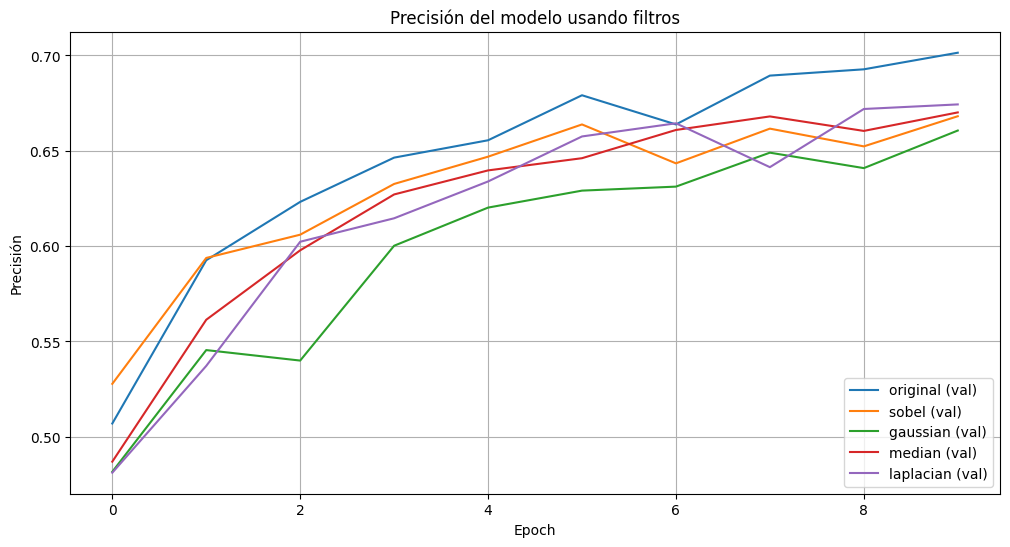


Precisión Final:
original  : 0.7014
sobel     : 0.6681
gaussian  : 0.6606
median    : 0.6701
laplacian : 0.6743


In [ ]:
plt.figure(figsize=(12, 6))

for filter_type in results:
    plt.plot(results[filter_type]['val_accuracy'], label=f'{filter_type} (val)')

plt.title('Precisión del modelo usando filtros')
plt.ylabel('Precisión')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Print final accuracies
print("\nPrecisión Final:")
for filter_type in results:
    final_acc = results[filter_type]['val_accuracy'][-1]
    print(f"{filter_type:10}: {final_acc:.4f}")



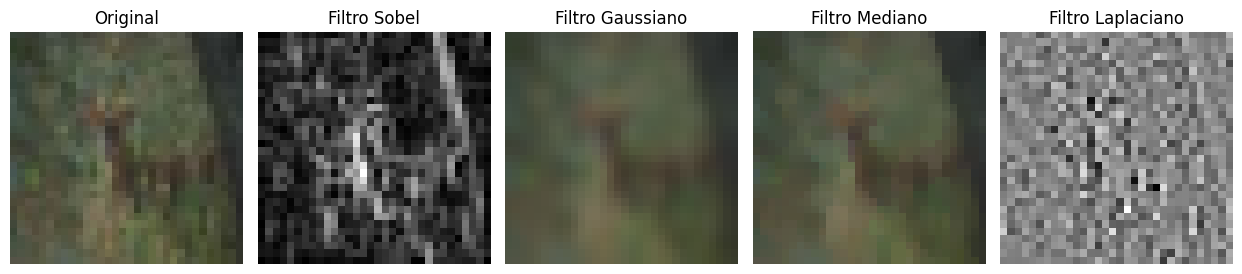

In [10]:
## Step 6: Visualize Filter Effects

# Display sample images with different filters
sample_idx = 10  # Change this to see different images

plt.figure(figsize=(15, 5))

plt.subplot(1, 6, 1)
plt.imshow(x_train[sample_idx])
plt.title('Original')
plt.axis('off')

plt.subplot(1, 6, 2)
plt.imshow(x_train_sobel[sample_idx])
plt.title('Filtro Sobel')
plt.axis('off')

plt.subplot(1, 6, 3)
plt.imshow(x_train_gaussian[sample_idx])
plt.title('Filtro Gaussiano')
plt.axis('off')

plt.subplot(1, 6, 4)
plt.imshow(x_train_median[sample_idx])
plt.title('Filtro Mediano')
plt.axis('off')

plt.subplot(1, 6, 5)
plt.imshow(x_train_laplacian[sample_idx])
plt.title('Filtro Laplaciano')
plt.axis('off')

plt.tight_layout()
plt.show()